# Biodiversity Intactness Index change in Phoenix, AZ

Author: Leilanie Rubinstein

Link to repo: https://github.com/leirubinstein/eds220-final-project (more content available here!)

## About

**Purpose:**

This exercise investigates the impacts of urban expansion on the Phoenix metropolitan area by analyzing a dataset that captures values for the Biodiversity Intactness Index between 2017 and 2020. In 2021, the [Washington Post identified Maricopa County](https://www.washingtonpost.com/nation/interactive/2021/land-development-urban-growth-maps/), which contains the Phoenix subdivision, as the county with the most significant increase in developed land since 2021. The rapid growth of urban sprawl can have negative implications for biodiversity and ecosystem health. We will visualize the BII in Phoenix in 2020, and highlight areas that experienced high biodiversity loss. 

**Highlights:**

- `rioxarray` raster manipulation
- `STAC` specification
- API catalog search
- boolean operations

**Dataset Descriptions**: 

- Biodiversity Intactness Index (BII) Time Series: Access the `io-biodiversity` collection from the [Microsoft Planetary Computer STAC catalog](https://planetarycomputer.microsoft.com/dataset/io-biodiversity). 

- Phoenix Subdivision Shapefile:  Download the Arizona counties polygon from the US Census Bureau. 

**References:**
- F. Gassert, J. Mazzarello, and S. Hyde, “Global 100m Projections of Biodiversity Intactness for the years 2017-2020 [Technical Whitepaper].” Aug. 2022. Available: https://ai4edatasetspublicassets.blob.core.windows.net/assets/pdfs/io-biodiversity/Biodiversity_Intactness_whitepaper.pdf

- U.S. Census Bureau. (2022). TIGER/Line Shapefiles: County Subdivisions, Arizona. Retrieved from https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2022&layergroup=County+Subdivisions


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import geopandas as gpd
import xarray as xr
import rioxarray as rioxr
import contextily as ctx
from pystac_client import Client
import planetary_computer
from IPython.display import Image


## Load Phoenix Data

We'll start by loading the Arizona subdivision shapefile and isolating the Phoenix area. The data is reprojected to EPSG:4326 (WGS84) to ensure compatibility with our other datasets.

In [3]:
pwd

'/Users/rubinstein/MEDS/EDS-220-ENV-DATASETS/eds220-final-project'

In [4]:
# Import Phoenix subdivision shapefile
root = os.path.join(
    "/",
    "Users",
    "rubinstein",
    "MEDS",
    "EDS-220-ENV-DATASETS",
    "eds220-final-project",
    "data",
)
az = gpd.read_file(os.path.join(root, "tl_2022_04_cousub", "tl_2022_04_cousub.shp"))

# Reproject CRS to EPSG:4326
az = az.to_crs("epsg:4326")

# Filter to Phoenix subdivision
phoenix = az[az["NAME"] == "Phoenix"]

## Phoenix Subdivision Map

To understand our study area, we'll create a contextual map showing the Phoenix subdivision using the `contextily` library to add a basemap. This helps visualize the geographic extent of our analysis.

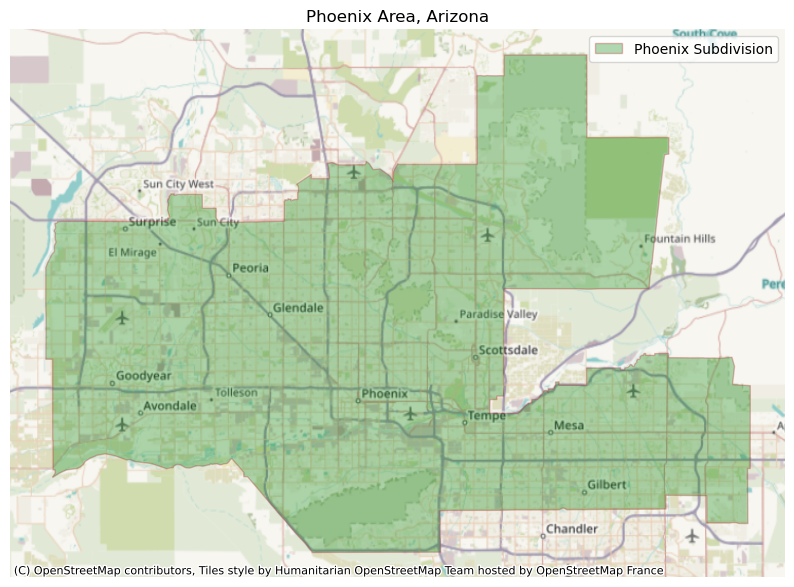

In [5]:
# Set figure size
fig, ax = plt.subplots(figsize=(10, 8))

# Remove axis for cleaner plot
ax.axis("off")

# Create a patch for the legend
legend_patch = Patch(
    facecolor="green",
    edgecolor="firebrick",
    alpha=0.3,
    label="Phoenix Subdivision",
)

# Plot Phoenix subdivision with label
phoenix.plot(
    ax=ax,
    color="green",
    edgecolor="firebrick",
    alpha=0.3,
    label="Phoenix Subdivision",
)

# Add basemap
ctx.add_basemap(ax, crs="epsg:4326")

plt.subplots_adjust(bottom=0.05)
ax.set_title("Phoenix Area, Arizona")

# Add legend
ax.legend(handles=[legend_patch])

plt.show()

## Load the BII Data

Obtain the BII Time Series data through a catalog search from the MPC STAC catalog. We will use the 2017 and 2020 rasters covering the Phoenix subdivision. For the bounding box, use the following coordinates:

`[-112.826843, 32.974108, -111.184387, 33.863574]`

In [6]:
# Temporal range of interest during growth of development
time_range = "2017-01-01/2021-01-01"

# Create bounding box for search
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

Use the `Client` function from the `pystac_client` package to access the catalog and search for the BII data. To get the items found in the search we use the `item_collection()` method.

This will return a list of items that match the search criteria. We can then filter the items to find the ones that contain the data we need.

In [7]:
# Access MPC catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Search MPC catalog
search = catalog.search(collections=["io-biodiversity"], bbox=bbox, datetime=time_range)

# Retrieve search items
items = search.item_collection()
print(f"Returned {len(items)} Items")
items

Returned 4 Items


The search returns 4 items. The 2017 and 2020 features are the last and first items in the search, respectively. We can access these items using the index of the list.

In [8]:
# Get the 2017 and 2020 BII items
item_2017 = items[3]
item_2020 = items[0]

## Process BII Data

The raster data for our current items is in the `data` asset. We open it using `rioxr.open_rasterio()` directly:

In [9]:
# Access raster data from item
io_bio2017 = rioxr.open_rasterio(item_2017.assets["data"].href)
io_bio2020 = rioxr.open_rasterio(item_2020.assets["data"].href)

We can subset the data to the Phoenix subdivision geometry obtained earlier. Notice that `band` is a dimension of length 1. We can go ahead and “squeeze” the raster to simplify it and drop this dimension.

In [10]:
# Subset the data and drop the `band` dimension
io_bio2017 = io_bio2017.rio.clip_box(*phoenix.total_bounds).rio.clip(phoenix.geometry)
io_bio2017 = io_bio2017.squeeze().drop_vars("band")

io_bio2020 = io_bio2020.rio.clip_box(*phoenix.total_bounds).rio.clip(phoenix.geometry)
io_bio2020 = io_bio2020.squeeze().drop_vars("band")


## Biodiversity Change Analysis

In order to visualize areas experiencing biodiversity loss, we need to calculate the percentage of area of the Phoenix subdivision with a BII of at least 0.75 in 2017 & 2020. First, let's look at the minimum and maximum BII values in 2017 and 2020.

In [11]:
# Find the minimum and maximum values of BII for 2017 and 2020
print("2017 Min value:", io_bio2017.min().values)
print("2017 Max value:", io_bio2017.max().values)
print("2020 Min value:", io_bio2020.min().values)
print("2020 Max value:", io_bio2020.max().values)

# Check that there are the same number of valid pixels for both arrays
assert io_bio2017.count().values == io_bio2020.count().values

2017 Min value: 0.07058962
2017 Max value: 0.8802183
2020 Min value: 0.08015034
2020 Max value: 0.8802183


To find the percent of area with BII values greater than or equal to 0.75, create a boolean mask of values where `True`indicates values greater than or equal to 0.75. Then, divide by the total number of pixels and multiply by 100 to obtain the percentage of area.

In [12]:
high_bii_2020 = io_bio2020 >= 0.75
percentage_2020 = (high_bii_2020.sum() / io_bio2020.count()) * 100

high_bii_2017 = io_bio2017 >= 0.75
percentage_2017 = (high_bii_2017.sum() / io_bio2017.count()) * 100

print(
    f"2017 Percentage of area of the Phoenix subdivision with BII >= 0.75: {percentage_2017.values:.2f}%"
)
print(
    f"2020 Percentage of area of the Phoenix subdivision with BII >= 0.75: {percentage_2020.values:.2f}%"
)

2017 Percentage of area of the Phoenix subdivision with BII >= 0.75: 7.13%
2020 Percentage of area of the Phoenix subdivision with BII >= 0.75: 6.49%


Notice that the percentage of area with BII values greater than or equal to 0.75 decreased by 0.64% from 2017 to 2020.

Check the type of the mask.

In [13]:
type(high_bii_2017)

xarray.core.dataarray.DataArray

The result is an an `xarray.DataArray`. To find the areas where BII was high in 2017 but not in 2020, we can perform a bitwise XOR operation, using `^`. A bitwise XOR operation will return `True` (1) if the values are different and `False` (0) if they are the same.

In [17]:
# Create a mask of areas that have lost high BII between 2017 and 2020
lost_bii = high_bii_2017 ^ high_bii_2020

In order to plot the mask, we need to make sure that all 0 values are set to `np.nan` so that they are not plotted. We can do this by using `xr.where()` to replace all 0 values with `np.nan`.

In [15]:
# Set 0 values to NA and all other values to 1 using `xr.where`
lost_bii = xr.where(lost_bii, 1, np.nan)
lost_bii

<xarray.DataArray (y: 583, x: 990)> Size: 5MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x            (x) float64 8kB -112.5 -112.5 -112.5 ... -111.6 -111.6 -111.6
  * y            (y) float64 5kB 33.81 33.81 33.81 33.81 ... 33.29 33.29 33.29
    spatial_ref  int64 8B 0

## Visualize BII Loss

To create a visualization showing areas within the Phoneix subdivision where biodiversity was lost, we can plot the 2020 BII raster and overlay the mask we created earlier to highlight areas where BII was at least 0.75 in 2017 but not in 2020.

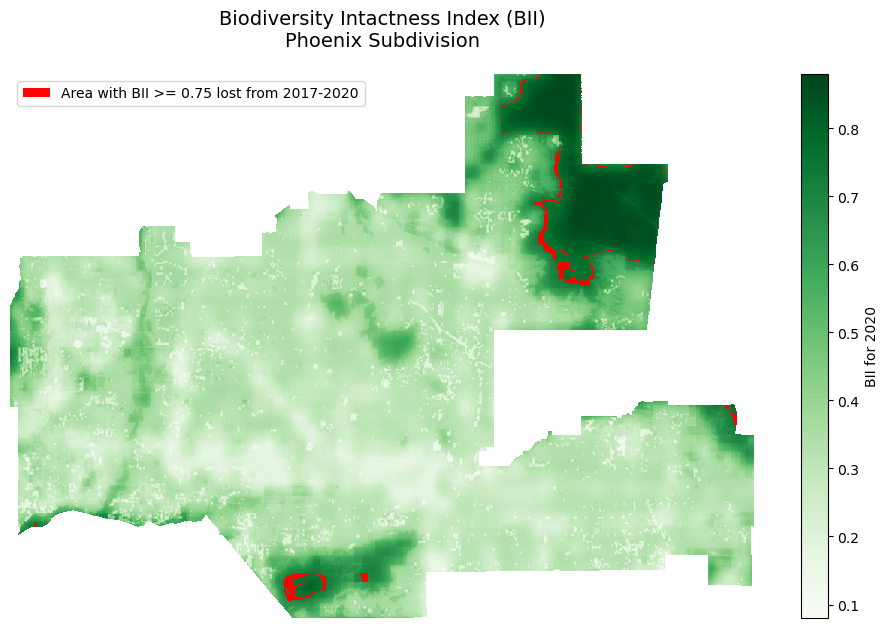

In [16]:
# Set aspect ratio and figure size
aspect = io_bio2020.rio.width / io_bio2020.rio.height
fig, ax = plt.subplots(figsize=(12, 12 / aspect))

# Plot BII in 2020
io_bio2020.plot(
    ax=ax,
    cmap="Greens",
    add_labels=False,
    add_colorbar=True,
    cbar_kwargs={
        "label": "BII for 2020",
    },
)

# Plot the mask of areas experiencing BII loss
lost_bii.plot(
    ax=ax,
    cmap=plt.cm.colors.ListedColormap(["red"]),
    add_labels=False,
    add_colorbar=False,
)

# Add legend
legend_elements = [
    Patch(facecolor="red", label="Area with BII >= 0.75 lost from 2017-2020")
]
ax.legend(handles=legend_elements, loc="upper left")

# Remove axis for cleaner plot
ax.axis("off")

# Add title
plt.title("Biodiversity Intactness Index (BII)\nPhoenix Subdivision", pad=20, size=14)

# show the plot
plt.show()

## Results and Interpretation

This map shows the Biodiversity Intactness Index (BII) for Phoenix, AZ in 2020. The red represents areas where BII was formerly measured at 0.75 or greater in 2017 but fell below that threshold in 2020. In 2017, 7.13% of the Phoenix subdivision had a BII of 0.75 or greater. This decreased to 6.49% in 2020. This analysis displays how rapid development has decreased biodiversity in the Phoenix area.

## References

F. Gassert, J. Mazzarello, and S. Hyde, “Global 100m Projections of Biodiversity Intactness for the years 2017-2020 [Technical Whitepaper].” Aug. 2022. Available: https://ai4edatasetspublicassets.blob.core.windows.net/assets/pdfs/io-biodiversity/Biodiversity_Intactness_whitepaper.pdf

U.S. Census Bureau. (2022). TIGER/Line Shapefiles: County Subdivisions, Arizona. Retrieved from https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2022&layergroup=County+Subdivisions